## A Full Walk-Through of the Tokens-to-Token Vision Transformer

*Kừ khi được giới thiệu vào năm 2017 với bài báo* Attention is All You Need, *transformers đã khẳng định mình là công nghệ tiên tiến trong xử lý ngôn ngữ tự nhiên (NLP). Vào năm 2021,* An Image is Worth 16x16 Words *đã thành công trong việc thích nghi transformers cho các tác vụ thị giác máy tính. Kể từ đó, nhiều kiến trúc dựa trên transformers đã được đề xuất cho các bài toán thị giác máy tính.*

**Vào năm 2021, _Tokens-to-Token ViT: Training Vision Transformers from Scratch on ImageNet_  đã giới thiệu Tokens-to-Token (T2T) ViT. Mô hình này nhằm mục tiêu loại bỏ yêu cầu huấn luyện trước nặng nề vốn có trong ViT gốc². Bài viết này sẽ đi qua T2T-ViT, bao gồm mã nguồn mở cho T2T-ViT, cũng như giải thích các thành phần lý thuyết. Tất cả mã nguồn sử dụng gói Python PyTorch.**


In [1]:
import os
import copy
import math
import typing
import cv2
import imageio.v2 as iio
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import timm

d:\Administrator\anaconda3\envs\cv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
figure_path = 'test_t2t'

In [3]:
NoneFloat = typing.Union[None, float]

## Tokens-to-Token ViT là gì?

Các vision transformer đầu tiên có khả năng đạt hiệu suất ngang với CNNs trong các tác vụ thị giác máy tính yêu cầu phải huấn luyện trước trên các bộ dữ liệu lớn và sau đó chuyển giao sang bài toán cụ thể. Tuy nhiên, việc huấn luyện trước trên các bộ dữ liệu như vậy không phải lúc nào cũng khả thi. Một lý do là bộ dữ liệu huấn luyện trước đã đạt kết quả tốt nhất trong *An Image is Worth 16x16 Words* (bộ dữ liệu JFT-300M) không có sẵn công khai. Hơn nữa, các vision transformer được thiết kế cho các tác vụ ngoài phân loại hình ảnh truyền thống có thể không có sẵn bộ dữ liệu huấn luyện trước lớn như vậy.

Vào năm 2021, *Tokens-to-Token ViT: Training Vision Transformers from Scratch on ImageNet* đã được công bố, giới thiệu một phương pháp có thể bỏ qua yêu cầu huấn luyện trước nặng nề của các vision transformer trước đó. Họ đạt được điều này bằng cách thay thế *patch tokenization* trong mô hình ViT² bằng một module Tokens-to-Token (T2T).

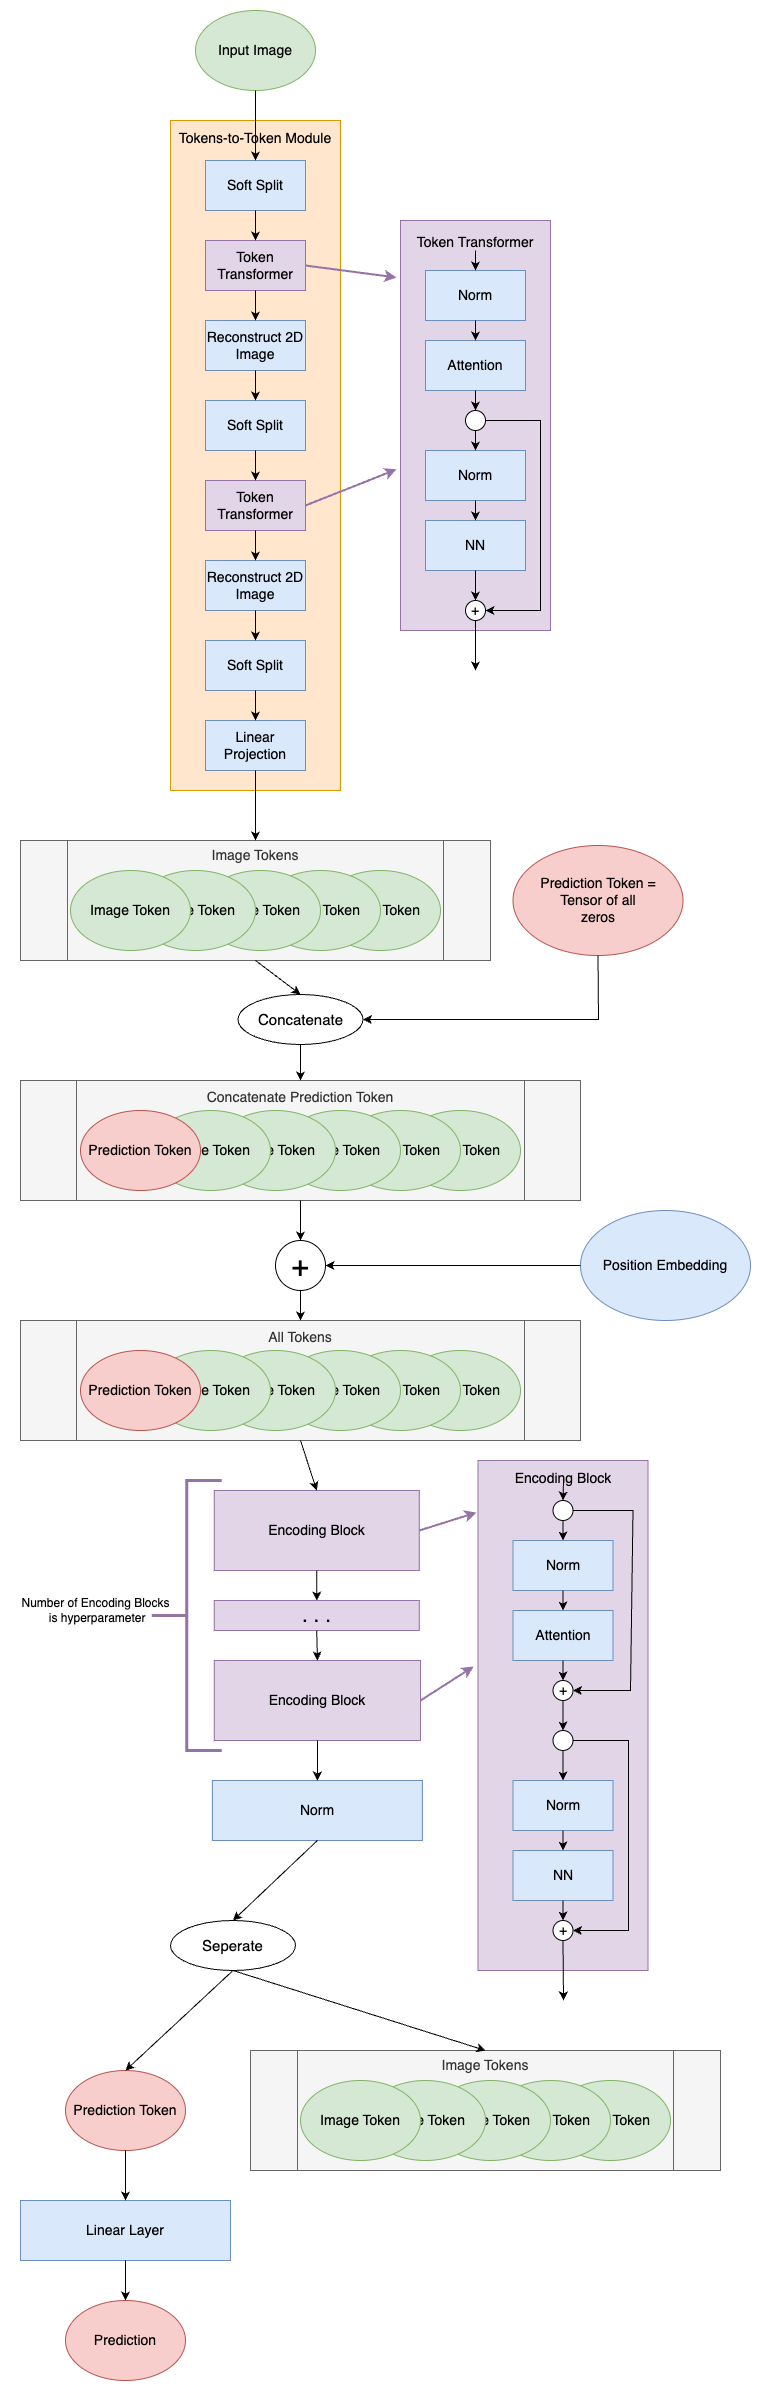

Vì module T2T là yếu tố tạo nên sự khác biệt của mô hình T2T-ViT, nên nó sẽ là trọng tâm của bài viết này. Để tìm hiểu sâu hơn về các thành phần của ViT, xem bài viết [Vision Transformers](https://towardsdatascience.com/vision-transformers-explained-a9d07147e4c8). Mã nguồn dựa trên mã nguồn GitHub công khai cho *Tokens-to-Token ViT* với một số chỉnh sửa. Các thay đổi đối với mã nguồn bao gồm, nhưng không giới hạn ở, việc sửa đổi để cho phép hình ảnh đầu vào không phải vuông và loại bỏ các lớp dropout.

## Module Tokens-to-Token (T2T)

Module T2T có nhiệm vụ xử lý hình ảnh đầu vào thành các token có thể sử dụng trong module ViT. Thay vì chỉ đơn giản chia hình ảnh đầu vào thành các patches để trở thành các token, module T2T tính toán tuần tự sự chú ý giữa các token và tổng hợp chúng lại với nhau để bắt được cấu trúc bổ sung trong hình ảnh và giảm độ dài tổng thể của token. Sơ đồ của module T2T được hiển thị dưới đây.

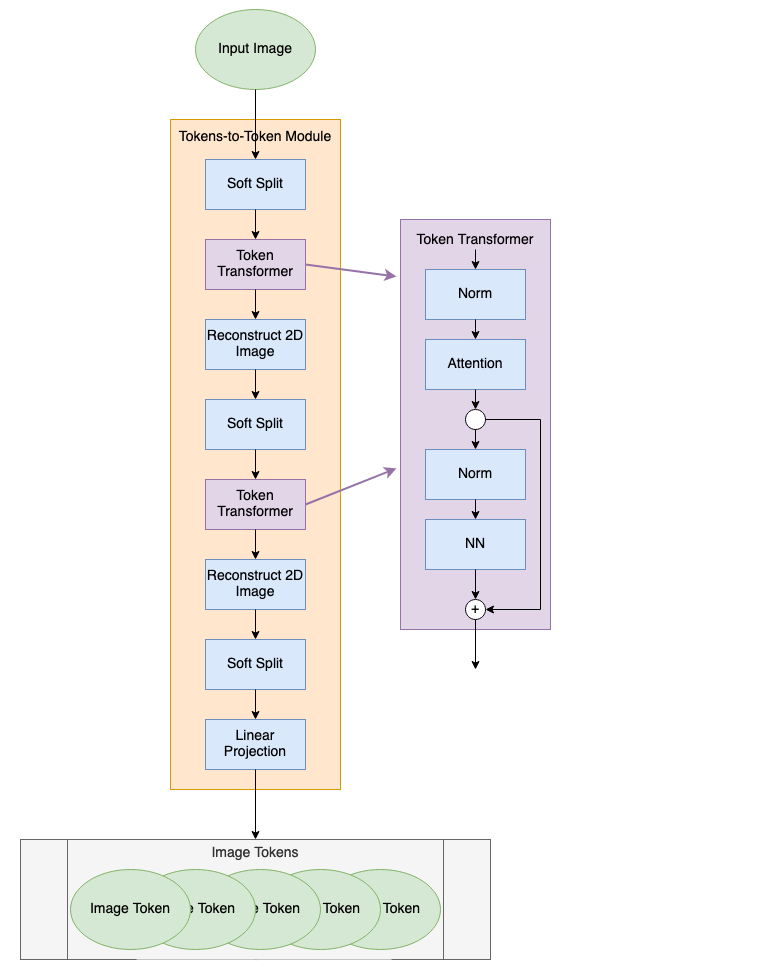

### Phân Tách Mềm (Soft Split)

Là lớp đầu tiên trong mô hình T2T-ViT, lớp phân tách mềm có nhiệm vụ tách hình ảnh thành một chuỗi các token. Các lớp phân tách mềm được hiển thị dưới dạng các khối màu xanh trong sơ đồ T2T. Khác với *patch tokenization* trong ViT gốc (đọc thêm về điều đó [tại đây](https://towardsdatascience.com/vision-transformers-explained-a9d07147e4c8)), các phân tách mềm trong T2T-ViT tạo ra các patches chồng lên nhau.

Hãy cùng xem một ví dụ về phân tách mềm trên tác phẩm nghệ thuật pixel *Mountain at Dusk* của Luis Zuno (@ansimuz)⁴. Tác phẩm gốc đã được cắt và chuyển đổi thành hình ảnh đơn kênh. Điều này có nghĩa là mỗi pixel có giá trị từ 0 đến 1. Hình ảnh đơn kênh thường được hiển thị dưới dạng ảnh đen trắng; tuy nhiên, chúng ta sẽ hiển thị nó với một bảng màu tím vì dễ nhìn hơn.

In [4]:
pwd

'd:\\Project\\INT3412E-55_CV_Group_project\\Model'

Mountain at Dusk is H = 60 and W = 100 pixels.




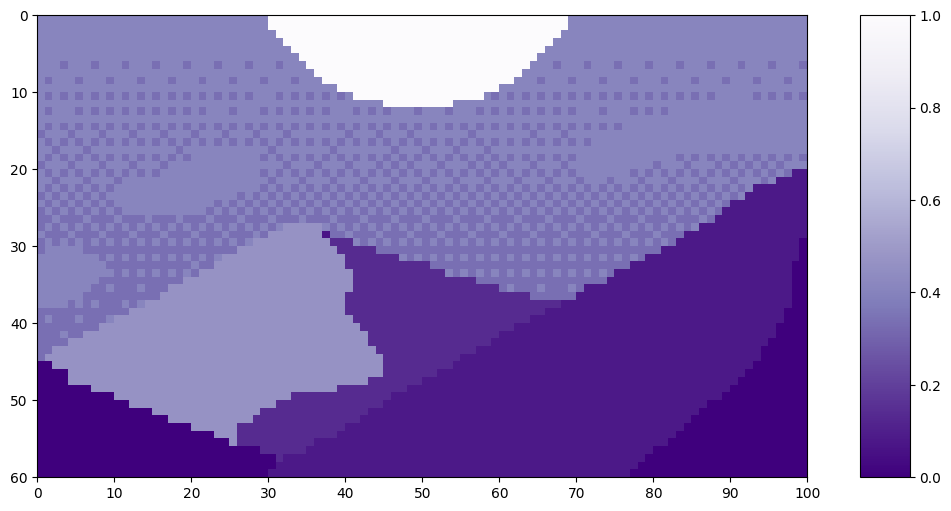

In [5]:
mountains = np.load(os.path.join(figure_path, 'mountains.npy'))

H = mountains.shape[0]
W = mountains.shape[1]
print('Mountain at Dusk is H =', H, 'and W =', W, 'pixels.')
print('\n')

fig = plt.figure(figsize=(10,6))
plt.imshow(mountains, cmap='Purples_r')
plt.xticks(np.arange(-0.5, W+1, 10), labels=np.arange(0, W+1, 10))
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
plt.clim([0,1])
cbar_ax = fig.add_axes([0.95, .11, 0.05, 0.77])
plt.clim([0, 1])
plt.colorbar(cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'mountains.png'), bbox_inches='tight')

Bức ảnh này có kích thước $H=60$ và $W=100$. Chúng ta sẽ sử dụng kích thước patch - hay còn gọi là *kernel* - là $k=20$. T2T-ViT thiết lập *stride* - một chỉ số đo độ chồng lấp - là $s=ceil(\frac{k}{2})$ và *padding* là $p=ceil(\frac{k}{4})$. Với ví dụ này, chúng ta sẽ sử dụng $s=10$ và $p=5$. Padding là các giá trị bằng 0, và chúng xuất hiện như màu tím đậm nhất.

Trước khi chúng ta có thể xem các patches được tạo ra trong phân tách mềm, chúng ta phải biết có bao nhiêu patches. Các phân tách mềm được triển khai dưới dạng các lớp `torch.nn.Unfold`. Để tính toán số lượng token mà phân tách mềm sẽ tạo ra, chúng ta sử dụng công thức sau:

$$num\_tokens = \lfloor \frac{h + 2*p - (k-1) -1}{s} +1 \rfloor * \lfloor \frac{w + 2*p - (k-1) -1}{s} +1 \rfloor$$

Trong đó, $h$ là chiều cao của ảnh gốc, $w$ là chiều rộng của ảnh gốc, $k$ là kích thước kernel, $s$ là kích thước stride, và $p$ là kích thước padding⁵. Công thức này giả sử kernel là hình vuông và stride cũng như padding là đối xứng. Ngoài ra, công thức này giả sử dilation bằng 1.

***Một chút về dilation**: PyTorch mô tả dilation là "kiểm soát khoảng cách giữa các điểm của kernel" và giới thiệu sơ đồ [tại đây](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md). Giá trị dilation=1 giữ nguyên kernel như bạn mong đợi, tất cả các pixel chạm nhau. Một người dùng trong [diễn đàn này](https://discuss.pytorch.org/t/why-the-default-dilation-value-in-conv2d-is-1/5612) gợi ý nghĩ về dilation như "mỗi phần tử thứ `dilation` được sử dụng." Trong trường hợp này, mỗi phần tử thứ 1 được sử dụng, có nghĩa là mọi phần tử đều được sử dụng.*

Hạng mục đầu tiên trong công thức $num\_tokens$ mô tả số lượng token theo chiều cao, trong khi hạng mục thứ hai mô tả số lượng token theo chiều rộng. Chúng ta sẽ triển khai điều này trong mã dưới đây:


In [6]:
def count_tokens(w, h, k, s, p):
	""" Function to count how many tokens are produced from a given soft split

		Args:
			w (int): starting width
			h (int): starting height
			k (int): kernel size
			s (int): stride size
			p (int): padding size

		Returns:
			new_w (int): number of tokens along the width
			new_h (int): number of tokens along the height
			total (int): total number of tokens created
	"""

	new_w = int(math.floor(((w + 2*p -1*(k-1) -1)/s)+1))
	new_h = int(math.floor(((h + 2*p -1*(k-1) -1)/s)+1))
	total = new_w * new_h

	return new_w, new_h, total

Sử dụng các kích thước trong ví dụ *Mountain at Dusk*:

In [7]:
k = 20
s = 10
p = 5
padded_H = H + 2*p
padded_W = W + 2*p
print('With padding, the image will be H =', padded_H, 'and W =', padded_W, 'pixels.\n') 

patches_w, patches_h, total_patches = count_tokens(w=W, h=H, k=k, s=s, p=p)
print('There will be', total_patches, 'patches as a result of the soft split;')
print(patches_h, 'along the height and', patches_w, 'along the width.')

With padding, the image will be H = 70 and W = 110 pixels.

There will be 60 patches as a result of the soft split;
6 along the height and 10 along the width.


Bây giờ, chúng ta có thể thấy cách phân tách mềm tạo ra các patches từ *Mountain at Dusk*.

In [8]:
mountains_w_padding = np.pad(mountains, pad_width = ((p, p), (p, p)), mode='constant', constant_values=0)

left_x = np.tile(np.arange(-0.5, padded_W-k+1, s), patches_h)
right_x = np.tile(np.arange(k-0.5, padded_W+1, s), patches_h)
top_y = np.repeat(np.arange(-0.5, padded_H-k+1, s), patches_w)
bottom_y = np.repeat(np.arange(k-0.5, padded_H+1, s), patches_w)

frame_paths = []

for i in range(total_patches):
    fig = plt.figure(figsize=(10,6))
    plt.imshow(mountains_w_padding, cmap='Purples_r')
    plt.clim([0,1])
    plt.xticks(np.arange(-0.5, W+2*p+1, 10), labels=np.arange(0, W+2*p+1, 10))
    plt.yticks(np.arange(-0.5, H+2*p+1, 10), labels=np.arange(0, H+2*p+1, 10))

    plt.plot([left_x[i], left_x[i], right_x[i], right_x[i], left_x[i]], [top_y[i], bottom_y[i], bottom_y[i], top_y[i], top_y[i]], color='w', lw=3, ls='-')

    for j in range(i):
        plt.plot([left_x[j], left_x[j], right_x[j], right_x[j], left_x[j]], [top_y[j], bottom_y[j], bottom_y[j], top_y[j], top_y[j]], color='w', lw=2, ls=':', alpha=0.5)
    save_path = os.path.join(figure_path, 'softsplit_gif', 'frame{:02d}'.format(i))+'.png'
    frame_paths.append(save_path)
    #fig.savefig(save_path, bbox_inches='tight')
    plt.close()
    
frames = []
for path in frame_paths:
    frames.append(iio.imread(path))

#iio.mimsave(os.path.join(figure_path, 'softsplit.gif'), frames, fps=2, loop=0)

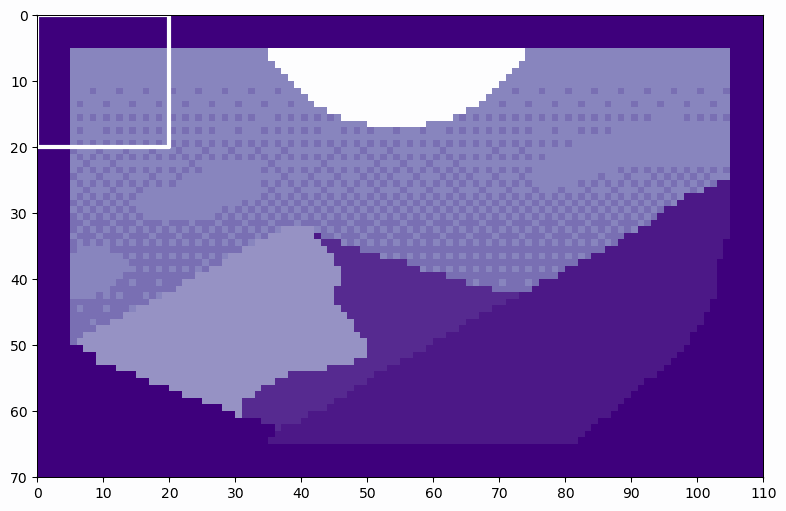

Chúng ta có thể thấy cách phân tách mềm tạo ra các patches chồng lên nhau. Bằng cách đếm các patches khi chúng di chuyển qua hình ảnh, chúng ta có thể thấy rằng có 6 patches theo chiều cao và 10 patches theo chiều rộng, chính xác như dự đoán. Bằng cách làm phẳng các patches này, chúng ta sẽ thấy các token kết quả. Hãy làm phẳng patch đầu tiên như một ví dụ.

Each patch will make a token of length 400.




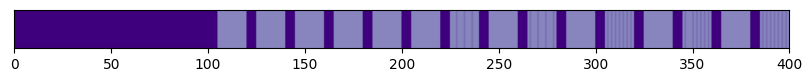

In [9]:
print('Each patch will make a token of length', str(k**2)+'.')
print('\n')

patch = mountains_w_padding[0:20, 0:20]
token = patch.reshape(1, k**2,)

fig = plt.figure(figsize=(10,1))
plt.imshow(token, cmap='Purples_r', aspect=20)
plt.clim([0, 1])
plt.xticks(np.arange(-0.5, k**2+1, 50), labels=np.arange(0, k**2+1, 50))
plt.yticks([]);
#plt.savefig(os.path.join(figure_path, 'mountains_w_padding_token01.png'), bbox_inches='tight')

Bạn có thể thấy padding xuất hiện trong token!

Khi được chuyển đến lớp tiếp theo, tất cả các token được tổng hợp lại với nhau trong một ma trận. Ma trận đó trông như sau:

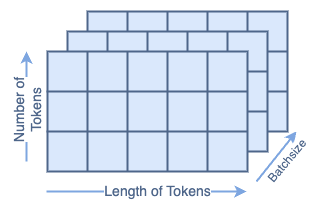

Đối với *Mountain at Dusk*, điều đó trông như sau:

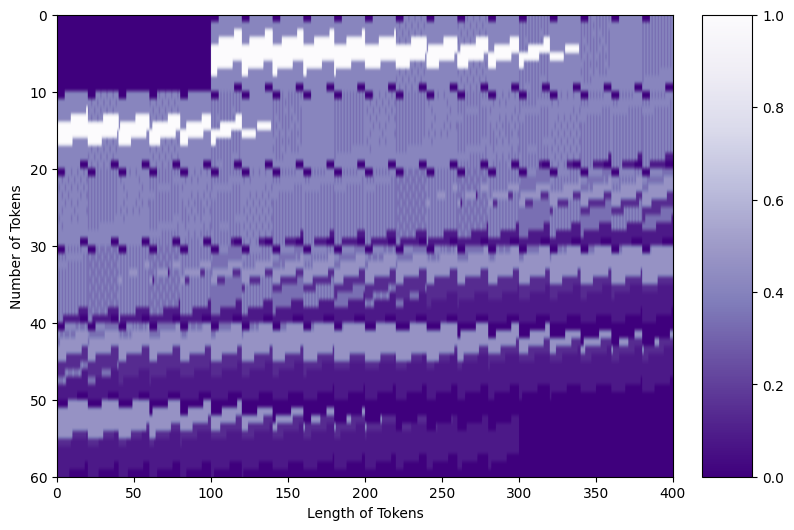

In [10]:
left_x = np.tile(np.arange(0, padded_W-k+1, s), patches_h)
right_x = np.tile(np.arange(k, padded_W+1, s), patches_h)
top_y = np.repeat(np.arange(0, padded_H-k+1, s), patches_w)
bottom_y = np.repeat(np.arange(k, padded_H+1, s), patches_w)

tokens = np.zeros((total_patches, k**2))
for i in range(total_patches):
    patch = mountains_w_padding[top_y[i]:bottom_y[i], left_x[i]:right_x[i]]
    tokens[i, :] = patch.reshape(1, k**2)
    
fig = plt.figure(figsize=(10,6))
plt.imshow(tokens, cmap='Purples_r', aspect=5)
plt.clim([0, 1])
plt.xticks(np.arange(-0.5, k**2+1, 50), labels=np.arange(0, k**2+1, 50))
plt.yticks(np.arange(-0.5, total_patches+1, 10), labels=np.arange(0, total_patches+1, 10))
plt.xlabel('Length of Tokens')
plt.ylabel('Number of Tokens')
plt.clim([0,1])
cbar_ax = fig.add_axes([0.85, .11, 0.05, 0.77])
plt.clim([0, 1])
plt.colorbar(cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'mountains_w_padding_tokens_matrix.png'), bbox_inches='tight')

Bạn có thể thấy các vùng padding lớn ở góc trên trái và góc dưới phải của ma trận, cũng như ở các đoạn nhỏ hơn xuyên suốt. Bây giờ, các token của chúng ta đã sẵn sàng để được chuyển sang bước tiếp theo.

### Mã Nền Tảng Cần Thiết Cho Token Transformer

Mã dưới đây phải được thực thi trước khi có thể chạy mã trong phần *Token Transformer*.

In [11]:
class Attention(nn.Module):
    def __init__(self, 
                dim: int,
                chan: int,
                num_heads: int=1,
                qkv_bias: bool=False,
                qk_scale: NoneFloat=None):

        """ Attention Module

            Args:
                dim (int): input size of a single token
                chan (int): resulting size of a single token (channels)
                num_heads(int): number of attention heads in MSA (only works if =1)
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
        """

        super().__init__()

        ## Define Constants
        self.num_heads = num_heads
        self.chan = chan
        self.head_dim = self.chan // self.num_heads
        self.scale = qk_scale or self.head_dim ** -0.5

        ## Define Layers
        self.qkv = nn.Linear(dim, chan * 3, bias=qkv_bias)
        ## Each token gets projected from starting token_len to channel length 3 times (once for each Q,K,V)
        self.proj = nn.Linear(chan, chan)

    def forward(self, x):
        if self.chan % self.num_heads != 0:
            raise ValueError('"Chan" must be evenly divisible by "num_heads".')
        B, N, C = x.shape
        ## Dimensions: (batch, num_tokens, token_len)

        ## Calcuate QKVs
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        ## Dimensions: (qkv, batch, heads, num_tokens, token_len = chan/num_heads = head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        ## Calculate Attention
        attn = (q * self.scale) @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        ## Dimensions: (batch, heads, num_tokens, num_tokens)

        ## Attention Layer
        x = (attn @ v).transpose(1, 2).reshape(B, N, self.chan)
        ## Dimensions: (batch, heads, num_tokens, token_len = chan)

        ## Projection Layers
        x = self.proj(x)

        ## Skip Connection Layer
        v = v.transpose(1, 2).reshape(B, N, self.chan)
        x = v + x     
        ## Because the original x has different size with current x, use v to do skip connection

        return x

In [12]:
class NeuralNet(nn.Module):
    def __init__(self,
    			in_chan: int,
    			hidden_chan: NoneFloat=None,
    			out_chan: NoneFloat=None,
    			act_layer = nn.GELU):
        """ Neural Network Module

            Args:
                in_chan (int): number of channels (features) at input
                hidden_chan (NoneFloat): number of channels (features) in the hidden layer;
                                        if None, number of channels in hidden layer is the same as the number of input channels
                out_chan (NoneFloat): number of channels (features) at output;
                                        if None, number of output channels is same as the number of input channels
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
        """

        super().__init__()

        ## Define Number of Channels
        hidden_chan = hidden_chan or in_chan
        out_chan = out_chan or in_chan

        ## Define Layers
        self.fc1 = nn.Linear(in_chan, hidden_chan)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_chan, out_chan)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

### Token Transformer

Thành phần tiếp theo của module T2T là Token Transformer, được đại diện bởi các khối màu tím.

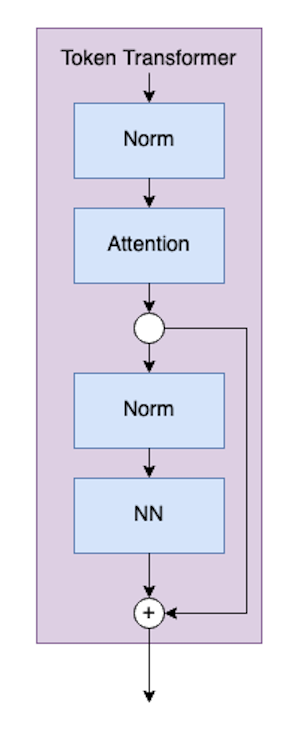

Mã cho lớp Token Transformer trông như sau:

In [13]:
class TokenTransformer(nn.Module):

    def __init__(self,
       dim: int,
       chan: int,
       num_heads: int,
       hidden_chan_mul: float=1.,
       qkv_bias: bool=False,
       qk_scale: NoneFloat=None,
       act_layer=nn.GELU,
       norm_layer=nn.LayerNorm):

        """ Token Transformer Module

            Args:
                dim (int): size of a single token
                chan (int): resulting size of a single token 
                num_heads (int): number of attention heads in MSA 
                hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet module
                qkv_bias (bool): determines if the attention qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation in the NeuralNet module
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Define Layers
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim,
              chan=chan,
              num_heads=num_heads,
              qkv_bias=qkv_bias,
              qk_scale=qk_scale)
        self.norm2 = norm_layer(chan)
        self.neuralnet = NeuralNet(in_chan=chan,
              hidden_chan=int(chan*hidden_chan_mul),
              out_chan=chan,
              act_layer=act_layer)

    def forward(self, x):
        x = self.attn(self.norm1(x))
        x = x + self.neuralnet(self.norm2(x))
        return x

Các tham số *chan*, *num_heads*, *qkv_bias*, và *qk_scale* định nghĩa các thành phần của module *Attention*. Việc tìm hiểu sâu về attention cho vistransformers có thể được để dành cho [lần khác](https://towardsdatascience.com/attention-for-vision-transformers-explained-70f83984c673).

Các tham số *hidden_chan_mul* và *act_layer* định nghĩa các thành phần của module *Neural Network*. Lớp kích hoạt có thể là bất kỳ lớp `torch.nn.modules.activation` nào. Lớp *norm_layer* có thể được chọn từ bất kỳ lớp `torch.nn.modules.normalization` nào.

Hãy cùng bước qua từng khối màu xanh trong sơ đồ. Chúng ta đang sử dụng kích thước token ban đầu là $7*7=49$, vì phân tách mềm đầu tiên có kernel mặc định là 7x7. Chúng ta sử dụng 64 kênh vì đó cũng là giá trị mặc định. Chúng ta sử dụng 100 token vì đó là một số đẹp. Chúng ta sử dụng kích thước batch là 13 vì đó là một số nguyên tố và sẽ không bị nhầm với các tham số khác. Chúng ta sử dụng 4 đầu (heads) vì nó chia đều các kênh; tuy nhiên, bạn sẽ không thấy chiều đầu (head dimension) trong Module Token Transformer.

In [14]:
# Define an Input
token_len = 7*7
channels = 64
num_tokens = 100
batch = 13
heads = 4
x = torch.rand(batch, num_tokens, token_len)
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])

# Define the Module
TT = TokenTransformer(dim=token_len, 
                      chan=channels, 
                      num_heads=heads, 
                      hidden_chan_mul=1.5, 
                      qkv_bias=False, 
                      qk_scale=None, 
                      act_layer=nn.GELU, 
                      norm_layer=nn.LayerNorm)
TT.eval();

Input dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 49


Đầu tiên, chúng ta truyền đầu vào qua một lớp chuẩn hóa (norm layer), điều này không làm thay đổi hình dạng của nó. Tiếp theo, nó được truyền qua module *Attention* đầu tiên, làm thay đổi độ dài của các token. Nhớ lại rằng một giải thích chi tiết hơn về Attention trong VisTransformers có thể được tìm thấy [tại đây](https://towardsdatascience.com/attention-for-vision-transformers-explained-70f83984c673).

In [15]:
x = TT.norm1(x)
print('After norm, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])
x = TT.attn(x)
print('After attention, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])

After norm, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 49
After attention, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 64


Bây giờ, chúng ta phải lưu trạng thái cho một lớp kết nối phân tách (split connection layer). Trong định nghĩa lớp thực tế, điều này được thực hiện một cách hiệu quả chỉ trong một dòng mã. Tuy nhiên, để giải thích chi tiết, chúng ta sẽ làm điều này một cách riêng biệt.

Tiếp theo, chúng ta có thể truyền qua một lớp chuẩn hóa khác và sau đó là module *Neural Network*. Lớp chuẩn hóa không thay đổi hình dạng của đầu vào. Mạng nơ-ron được cấu hình sao cho cũng không thay đổi hình dạng.

Bước cuối cùng là kết nối phân tách, cũng không thay đổi hình dạng của đầu vào.

In [16]:
y = TT.norm2(x)
print('After norm, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])
y = TT.neuralnet(y)
print('After neural net, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])
y = y + x
print('After split connection, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])

After norm, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 64
After neural net, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 64
After split connection, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 64


### Neural Network Module

Module Neural Network (NN) là một thành phần con của module token transformer. Module mạng nơ-ron rất đơn giản, bao gồm một lớp kết nối đầy đủ (fully-connected layer), một lớp kích hoạt (activation layer), và một lớp kết nối đầy đủ khác. Lớp kích hoạt có thể là bất kỳ lớp `torch.nn.modules.activation` nào, được truyền vào như một đầu vào của module. Module NN có thể được cấu hình để thay đổi hình dạng của đầu vào, hoặc duy trì hình dạng ban đầu. Chúng ta sẽ không đi qua mã nguồn của phần này, vì mạng nơ-ron rất phổ biến trong học máy và không phải là trọng tâm của bài viết này. Tuy nhiên, mã nguồn của module NN được trình bày dưới đây.

In [17]:
class NeuralNet(nn.Module):
    def __init__(self,
       in_chan: int,
       hidden_chan: NoneFloat=None,
       out_chan: NoneFloat=None,
       act_layer = nn.GELU):
        """ Neural Network Module

            Args:
                in_chan (int): number of channels (features) at input
                hidden_chan (NoneFloat): number of channels (features) in the hidden layer;
                                        if None, number of channels in hidden layer is the same as the number of input channels
                out_chan (NoneFloat): number of channels (features) at output;
                                        if None, number of output channels is same as the number of input channels
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
        """

        super().__init__()

        ## Define Number of Channels
        hidden_chan = hidden_chan or in_chan
        out_chan = out_chan or in_chan

        ## Define Layers
        self.fc1 = nn.Linear(in_chan, hidden_chan)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_chan, out_chan)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

### Tái Tạo Hình Ảnh

Các lớp tái tạo hình ảnh cũng được hiển thị dưới dạng các khối màu xanh trong sơ đồ T2T. Hình dạng của đầu vào cho các lớp tái tạo hình ảnh có dạng (batch, num_tokens, tokensize=channels). Nếu chúng ta chỉ nhìn vào một batch, nó trông như sau:

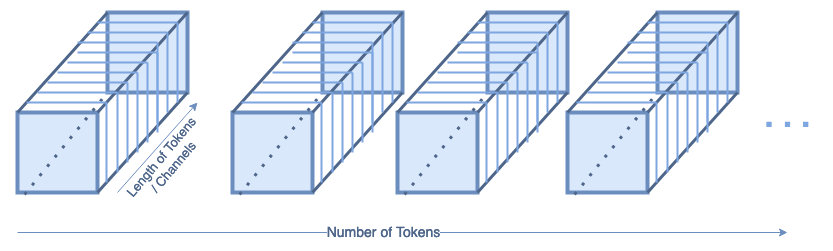

Các lớp tái tạo hình ảnh sẽ thay đổi hình dạng của các token thành một hình ảnh 2D lần nữa, trông như sau:

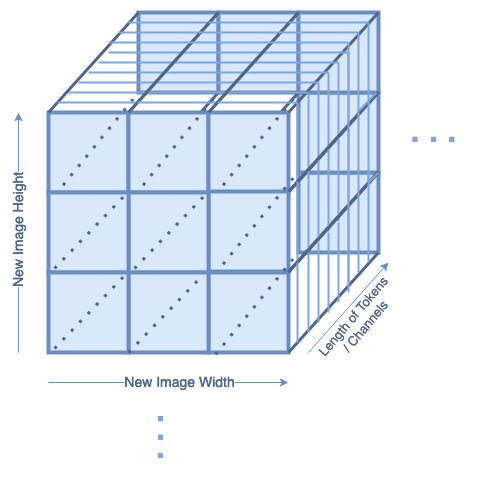

Trong mỗi batch, sẽ có *tokensize = channel* số lượng hình ảnh được tái tạo. Điều này được xử lý giống như khi hình ảnh là màu và có ba kênh màu.

Mã tái tạo không được đóng gói trong một hàm riêng. Tuy nhiên, một ví dụ được trình bày dưới đây:

```
W, H, _ = count_tokens(w, h, k, s, p)
x = x.transpose(1,2).reshape(B, C, H, W)
```

### All Together

Now we're ready to examine the whole T2T module put together! The model class for the T2T module looks like:

In [18]:
class Tokens2Token(nn.Module):
    def __init__(self, 
                img_size: tuple[int, int, int]=(1, 1000, 300), 
                token_chan:  int=64,
                token_len: int=768,):
    
        """ Tokens-to-Token Module
            Args:
                img_size (tuple[int, int, int]): size of input (channels, height, width)
                token_chan (int): number of token channels inside the TokenTransformers
                token_len (int): desired length of an output token
        """

        super().__init__()

        ## Seperating Image Size
        C, H, W = img_size
        self.token_chan = token_chan
        ## Dimensions: (channels, height, width)

        ## Define the Soft Split Layers
        self.soft_split0 = nn.Unfold(kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
        self.soft_split1 = nn.Unfold(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.soft_split2 = nn.Unfold(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

        ## Determining Number of Output Tokens
        W, H, _ = count_tokens(w=W, h=H, k=7, s=4, p=2)
        W, H, _ = count_tokens(w=W, h=H, k=3, s=2, p=1)
        _, _, T = count_tokens(w=W, h=H, k=3, s=2, p=1)
        self.num_tokens = T


        ## Define the Transformer Layers
        self.transformer1 = TokenTransformer(dim= C * 7 * 7, 
        chan=token_chan,
        num_heads=1,
        hidden_chan_mul=1.0)
        self.transformer2 = TokenTransformer(dim=token_chan * 3 * 3, 
        chan=token_chan, 
        num_heads=1, 
        hidden_chan_mul=1.0)

        ## Define the Projection Layer
        self.project = nn.Linear(token_chan * 3 * 3, token_len)
  
    def forward(self, x):

        B, C, H, W = x.shape
        ## Dimensions: (batch, channels, height, width)

        ## Initial Soft Split
        x = self.soft_split0(x).transpose(1, 2)

        ## Token Transformer 1
        x = self.transformer1(x)

        ## Reconstruct 2D Image
        W, H, _ = count_tokens(w=W, h=H, k=7, s=4, p=2)
        x = x.transpose(1,2).reshape(B, self.token_chan, H, W)

        ## Soft Split 1
        x = self.soft_split1(x).transpose(1, 2)

        ## Token Transformer 2
        x = self.transformer2(x)

        ## Reconstruct 2D Image
        W, H, _ = count_tokens(w=W, h=H, k=3, s=2, p=1)
        x = x.transpose(1,2).reshape(B, self.token_chan, H, W)

        ## Soft Split 2
        x = self.soft_split2(x).transpose(1, 2)

        ## Project Tokens to desired length
        x = self.project(x)

        return x

Hãy cùng bước qua quá trình truyền qua mạng (forward pass). Vì chúng ta đã xem xét các thành phần chi tiết hơn, phần này sẽ coi chúng như các hộp đen (black boxes): chúng ta chỉ xem đầu vào và đầu ra.

Chúng ta sẽ định nghĩa một đầu vào cho mạng có hình dạng 1x400x100 để đại diện cho một hình ảnh đơn sắc (một kênh) dạng hình chữ nhật. Chúng ta sử dụng 64 kênh và độ dài token là 768 vì đó là các giá trị mặc định. Chúng ta sử dụng kích thước batch là 13 vì đó là một số nguyên tố và sẽ không bị nhầm lẫn với các tham số khác.

In [19]:
# Define an Input
H = 400
W = 100
channels = 64
batch = 13
x = torch.rand(batch, 1, H, W)
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of input channels:', x.shape[1], '\n\timage size:', (x.shape[2], x.shape[3]))

# Define the Module
T2T = Tokens2Token(img_size=(1, H, W), token_chan=64, token_len=768)
T2T.eval();

Input dimensions are
	batchsize: 13 
	number of input channels: 1 
	image size: (400, 100)


Hình ảnh đầu vào đầu tiên được truyền qua một lớp phân tách mềm (soft split layer) với $kernel = 7$, $stride = 4$, và $padding = 2$. Độ dài của các token sẽ bằng kích thước của kernel ($7*7=49$) nhân với số lượng kênh (= 1 đối với đầu vào đơn sắc). Chúng ta có thể sử dụng hàm `count_tokens` để tính toán số lượng token sẽ có sau khi phân tách mềm.

In [20]:
# Count Tokens
k = 7
s = 4
p = 2
_, _, T = count_tokens(w=W, h=H, k=k, s=s, p=p)
print('There should be', T, 'tokens after the soft split.')
print('They should be of length', k, '*', k, '* 1 =', k*k*1)

# Perform the Soft Split
x = T2T.soft_split0(x)
print('Dimensions after soft split are\n\tbatchsize:', x.shape[0], '\n\ttoken length:', x.shape[1], '\n\tnumber of tokens:', x.shape[2])
x = x.transpose(1, 2)

There should be 2500 tokens after the soft split.
They should be of length 7 * 7 * 1 = 49
Dimensions after soft split are
	batchsize: 13 
	token length: 49 
	number of tokens: 2500


Tiếp theo, chúng ta truyền qua *Token Transformer* đầu tiên. Điều này không ảnh hưởng đến kích thước batch hay số lượng token, nhưng nó thay đổi độ dài của các token thành *channels* = 64.

In [21]:
x = T2T.transformer1(x)
print('Dimensions after transformer are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

Dimensions after transformer are
	batchsize: 13 
	number of tokens: 2500 
	token length: 64


Bây giờ, chúng ta tái tạo các token lại thành hình ảnh 2D. Hàm `count_tokens` một lần nữa có thể cho chúng ta biết hình dạng của hình ảnh mới. Nó sẽ có 64 kênh, giống như độ dài của các token ra khỏi *Token Transformer*.

In [22]:
W, H, _ = count_tokens(w=W, h=H, k=k, s=s, p=p)
print('The reconstructed image should have shape', (H, W))

x = x.transpose(1,2).reshape(batch, T2T.token_chan, H, W)
print('Dimensions of reconstructed image are\n\tbatchsize:', x.shape[0], '\n\tnumber of input channels:', x.shape[1], '\n\timage size:', (x.shape[2], x.shape[3]))

The reconstructed image should have shape (100, 25)
Dimensions of reconstructed image are
	batchsize: 13 
	number of input channels: 64 
	image size: (100, 25)


Giờ đây, chúng ta đã có một hình ảnh 2D trở lại, chúng ta quay lại với phân tách mềm (soft split)! Khối mã tiếp theo sẽ đi qua phân tách mềm thứ hai, *Token Transformer* thứ hai, và tái tạo hình ảnh thứ hai.

In [23]:
# Soft Split
k = 3
s = 2
p = 1
_, _, T = count_tokens(w=W, h=H, k=k, s=s, p=p)
print('There should be', T, 'tokens after the soft split.')
print('They should be of length', k, '*', k, '*', T2T.token_chan, '=', k*k*T2T.token_chan)
x = T2T.soft_split1(x)
print('Dimensions after soft split are\n\tbatchsize:', x.shape[0], '\n\ttoken length:', x.shape[1], '\n\tnumber of tokens:', x.shape[2])
x = x.transpose(1, 2)

# Token Transformer
x = T2T.transformer2(x)
print('Dimensions after transformer are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

# Reconstruction
W, H, _ = count_tokens(w=W, h=H, k=k, s=s, p=p)
print('The reconstructed image should have shape', (H, W))
x = x.transpose(1,2).reshape(batch, T2T.token_chan, H, W)
print('Dimensions of reconstructed image are\n\tbatchsize:', x.shape[0], '\n\tnumber of input channels:', x.shape[1], '\n\timage size:', (x.shape[2], x.shape[3]))

There should be 650 tokens after the soft split.
They should be of length 3 * 3 * 64 = 576
Dimensions after soft split are
	batchsize: 13 
	token length: 576 
	number of tokens: 650
Dimensions after transformer are
	batchsize: 13 
	number of tokens: 650 
	token length: 64
The reconstructed image should have shape (50, 13)
Dimensions of reconstructed image are
	batchsize: 13 
	number of input channels: 64 
	image size: (50, 13)


Từ hình ảnh tái tạo này, chúng ta đi qua một phân tách mềm cuối cùng. Nhớ lại rằng đầu ra của module T2T sẽ là một danh sách các token.

In [24]:
# Soft Split
k = 3
s = 2
p = 1
_, _, T = count_tokens(w=W, h=H, k=k, s=s, p=p)
print('There should be', T, 'tokens after the soft split.')
print('They should be of length', k, '*', k, '*', T2T.token_chan, '=', k*k*T2T.token_chan)
x = T2T.soft_split2(x)
print('Dimensions after soft split are\n\tbatchsize:', x.shape[0], '\n\ttoken length:', x.shape[1], '\n\tnumber of tokens:', x.shape[2])
x = x.transpose(1, 2)

There should be 175 tokens after the soft split.
They should be of length 3 * 3 * 64 = 576
Dimensions after soft split are
	batchsize: 13 
	token length: 576 
	number of tokens: 175


Lớp cuối cùng trong module T2T là một lớp tuyến tính (linear layer) để chiếu các token về kích thước đầu ra mong muốn. Chúng ta đã chỉ định kích thước đó là $token\_len=768$.

In [25]:
x = T2T.project(x)
print('Output dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

Output dimensions are
	batchsize: 13 
	number of tokens: 175 
	token length: 768


## ViT Backbone

Từ module T2T, các token sẽ đi qua một ViT backbone. Điều này giống hệt với backbone của mô hình ViT được mô tả trong [2]. Bài viết [Vision Transformers](https://towardsdatascience.com/vision-transformers-explained-a9d07147e4c8) sẽ giải thích chi tiết về mô hình ViT và ViT backbone. Mã nguồn được sao chép dưới đây, nhưng chúng ta sẽ không đi qua nó. Bạn có thể tham khảo bài viết [tại đây](https://towardsdatascience.com/vision-transformers-explained-a9d07147e4c8) và sau đó quay lại!

In [26]:
class Encoding(nn.Module):

    def __init__(self,
       dim: int,
       num_heads: int=1,
       hidden_chan_mul: float=4.,
       qkv_bias: bool=False,
       qk_scale: NoneFloat=None,
       act_layer=nn.GELU, 
       norm_layer=nn.LayerNorm):
        
        """ Encoding Block

            Args:
                dim (int): size of a single token
                num_heads(int): number of attention heads in MSA
                hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Define Layers
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim=dim,
                            chan=dim,
                            num_heads=num_heads,
                            qkv_bias=qkv_bias,
                            qk_scale=qk_scale)
        self.norm2 = norm_layer(dim)
        self.neuralnet = NeuralNet(in_chan=dim,
                                hidden_chan=int(dim*hidden_chan_mul),
                                out_chan=dim,
                                act_layer=act_layer)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.neuralnet(self.norm2(x))
        return x

In [27]:
class ViT_Backbone(nn.Module):
    def __init__(self,
                preds: int=1,
                token_len: int=768,
                num_heads: int=1,
                Encoding_hidden_chan_mul: float=4.,
                depth: int=12,
                qkv_bias=False,
                qk_scale=None,
                act_layer=nn.GELU,
                norm_layer=nn.LayerNorm):

        """ VisTransformer Backbone
            Args:
                preds (int): number of predictions to output
                token_len (int): length of a token
                num_heads(int): number of attention heads in MSA
                Encoding_hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component of the Encoding Module
                depth (int): number of encoding blocks in the model
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                 if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Defining Parameters
        self.num_heads = num_heads
        self.Encoding_hidden_chan_mul = Encoding_hidden_chan_mul
        self.depth = depth

        ## Defining Token Processing Components
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.token_len))
        self.pos_embed = nn.Parameter(data=get_sinusoid_encoding(num_tokens=self.num_tokens+1, token_len=self.token_len), requires_grad=False)

        ## Defining Encoding blocks
        self.blocks = nn.ModuleList([Encoding(dim = self.token_len, 
                                               num_heads = self.num_heads,
                                               hidden_chan_mul = self.Encoding_hidden_chan_mul,
                                               qkv_bias = qkv_bias,
                                               qk_scale = qk_scale,
                                               act_layer = act_layer,
                                               norm_layer = norm_layer)
             for i in range(self.depth)])

        ## Defining Prediction Processing
        self.norm = norm_layer(self.token_len)
        self.head = nn.Linear(self.token_len, preds)

        ## Make the class token sampled from a truncated normal distrobution 
        timm.layers.trunc_normal_(self.cls_token, std=.02)

    def forward(self, x):
        ## Assumes x is already tokenized

        ## Get Batch Size
        B = x.shape[0]
        ## Concatenate Class Token
        x = torch.cat((self.cls_token.expand(B, -1, -1), x), dim=1)
        ## Add Positional Embedding
        x = x + self.pos_embed
        ## Run Through Encoding Blocks
        for blk in self.blocks:
            x = blk(x)
        ## Take Norm
        x = self.norm(x)
        ## Make Prediction on Class Token
        x = self.head(x[:, 0])
        return x

## Complete Code

Để tạo ra module T2T-ViT hoàn chỉnh, chúng ta sử dụng module *T2T* và *ViT Backbone*.

In [28]:
class T2T_ViT(nn.Module):
    def __init__(self, 
                img_size: tuple[int, int, int]=(1, 1700, 500),
                softsplit_kernels: tuple[int, int, int]=(31, 3, 3),
                preds: int=1,
                token_len: int=768,
                token_chan:  int=64,
                num_heads: int=1,
                T2T_hidden_chan_mul: float=1.,
                Encoding_hidden_chan_mul: float=4.,
                depth: int=12,
                qkv_bias=False,
                qk_scale=None,
                act_layer=nn.GELU,
                norm_layer=nn.LayerNorm):

        """ Tokens-to-Token VisTransformer Model

            Args:
                img_size (tuple[int, int, int]): size of input (channels, height, width)
                softsplit_kernels (tuple[int int, int]): size of the square kernel for each of the soft split layers, sequentially
                preds (int): number of predictions to output
                token_len (int): desired length of an output token
                token_chan (int): number of token channels inside the TokenTransformers
                num_heads(int): number of attention heads in MSA (only works if =1)
                T2T_hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component of the Tokens-to-Token (T2T) Module
                Encoding_hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component of the Encoding Module
                depth (int): number of encoding blocks in the model
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Defining Parameters
        self.img_size = img_size
        C, H, W = self.img_size
        self.softsplit_kernels = softsplit_kernels
        self.token_len = token_len
        self.token_chan = token_chan
        self.num_heads = num_heads
        self.T2T_hidden_chan_mul = T2T_hidden_chan_mul
        self.Encoding_hidden_chan_mul = Encoding_hidden_chan_mul
        self.depth = depth

        ## Defining Tokens-to-Token Module
        self.tokens_to_token = Tokens2Token(img_size = self.img_size, 
                                            softsplit_kernels = self.softsplit_kernels,
                                            num_heads = self.num_heads,
              token_chan = self.token_chan,
              token_len = self.token_len,
              hidden_chan_mul = self.T2T_hidden_chan_mul,
              qkv_bias = qkv_bias,
              qk_scale = qk_scale,
              act_layer = act_layer,
              norm_layer = norm_layer)
        self.num_tokens = self.tokens_to_token.num_tokens

        ## Defining Token Processing Components
        self.vit_backbone = ViT_Backbone(preds = preds,
          token_len = self.token_len,
          num_heads = self.num_heads,
          Encoding_hidden_chan_mul = self.Encoding_hidden_chan_mul,
          depth = self.depth,
          qkv_bias = qkv_bias,
             qk_scale = qk_scale,
             act_layer = act_layer,
             norm_layer = norm_layer)

        ## Initialize the Weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """ Initialize the weights of the linear layers & the layernorms
        """
        ## For Linear Layers
        if isinstance(m, nn.Linear):
            ## Weights are initialized from a truncated normal distrobution
            timmm.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                ## If bias is present, bias is initialized at zero
                nn.init.constant_(m.bias, 0)
        ## For Layernorm Layers
        elif isinstance(m, nn.LayerNorm):
            ## Weights are initialized at one
            nn.init.constant_(m.weight, 1.0)
            ## Bias is initialized at zero
            nn.init.constant_(m.bias, 0)
            
    @torch.jit.ignore ##Tell pytorch to not compile as TorchScript
    def no_weight_decay(self):
        """ Used in Optimizer to ignore weight decay in the class token
        """
        return {'cls_token'}

    def forward(self, x):
        x = self.tokens_to_token(x)
        x = self.vit_backbone(x)
        return x

Trong *Mô hình T2T-ViT*, các tham số *img_size* và *softsplit_kernels* xác định các phân tách mềm trong module T2T. Các tham số *num_heads*, *token_chan*, *qkv_bias*, và *qk_scale* xác định các module *Attention* trong các module *Token Transformer*, nằm trong module *T2T*. Các tham số *T2T_hidden_chan_mul* và *act_layer* xác định module *NN* trong module *Token Transformer*. Tham số *token_len* xác định các lớp tuyến tính trong module *T2T*. Tham số *norm_layer* xác định các lớp chuẩn hóa (norms).

Tương tự, các tham số *num_heads*, *token_len*, *qkv_bias*, và *qk_scale* xác định các module *Attention* trong các *Encoding Blocks*, nằm trong *ViT Backbone*. Các tham số *Encoding_hidden_chan_mul* và *act_layer* xác định module *NN* trong các *Encoding Blocks*. Tham số *depth* xác định số lượng *Encoding Blocks* trong *ViT Backbone*. Tham số *norm_layer* xác định các lớp chuẩn hóa. Tham số *preds* xác định đầu ra dự đoán trong *ViT Backbone*.

Tham số *act_layer* có thể là bất kỳ lớp `torch.nn.modules.activation`⁶ nào, và tham số *norm_layer* có thể là bất kỳ lớp `torch.nn.modules.normalization`⁷ nào.

Phương thức *\_init_weights* thiết lập trọng số ban đầu tùy chỉnh cho việc huấn luyện mô hình. Phương thức này có thể bị xóa để khởi tạo tất cả các trọng số và độ lệch (bias) một cách ngẫu nhiên. Như đã triển khai, trọng số của các lớp tuyến tính được khởi tạo dưới dạng phân phối chuẩn cắt ngắn (truncated normal distribution); độ lệch của các lớp tuyến tính được khởi tạo là zero; trọng số của các lớp chuẩn hóa được khởi tạo là một; độ lệch của các lớp chuẩn hóa được khởi tạo là zero.